In [2]:

%load_ext autoreload
%autoreload 2
from torch import device
from abc import ABC
import warnings
import numpy as np
import pandas as pd
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from dataset.signal_dataset import SignalDataset
from sklearn.metrics import classification_report
import re
from pathlib import Path
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y
import yaml
import re
import librosa
from pathlib import Path
import abc
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.fft import fft
import yaml
from typing import Callable
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from torch.utils.data import DataLoader, Dataset, random_split
from torch.utils.tensorboard import SummaryWriter
from tqdm import trange
import seaborn as sns

import tsaug
import torchaudio.transforms as T
import torchaudio
from IPython.display import Audio
from matplotlib.patches import Rectangle

In [1]:

sample_rate = 1562500
channel_1 = 'ch1'
channel_2 = 'ch2'
channel_3 = 'ch3'
signal_data_dir = "/mnt/home2/Motor_project/AE_PETR_loziska/"

train_config =[{"label": (int(i.stem) - 1) // 4,
                  "channels": len(list(i.glob('*' + channel_3 + '.bin'))),
                  "interval": [0, int(4.5 * sample_rate)],
                  "bin_path": list(i.glob('*' + channel_3 + '.bin'))[0]}
                 for i in Path(signal_data_dir).glob('*') if re.search(r'\d$', i.stem)]


test_config = [{"label": (int(i.stem) - 1) // 4,
                 "channels": len(list(i.glob('*' + channel_2 + '.bin'))),
                 "interval": [int(4.5 * sample_rate), int(5 * sample_rate)],
                 "bin_path": list(i.glob('*' + channel_2 + '.bin'))[0]}
                for i in Path(signal_data_dir).glob('*') if re.search(r'\d$', i.stem)]

noise_config = {"intensity": 1,
                "bin_path": Path("/mnt/home2/Motor_project/AE_PETR_loziska/prevodovka/AE-DATA-conti-7394086655261458-ch1.bin")}

train_set = SignalDataset(step=10000, window_size=5000, bin_setup=train_config, noise = noise_config, source_dtype="float32")
test_set = SignalDataset(step=10000, window_size=5000, bin_setup=test_config, source_dtype="float32")


NameError: name 'Path' is not defined

In [ ]:
len(train_set) + len(test_set)

In [ ]:

x = torch.from_numpy(train_set[6][0])
x_reshape = torch.reshape(x, (1, -1))
transform = T.Spectrogram(n_fft=512, hop_length=256) 

spectrogram = transform(x)

In [4]:
spectrogram.shape

torch.Size([1, 513, 17])

In [5]:

def plot_waveform(waveform, sr, title="Waveform", ax=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)

In [6]:
def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")

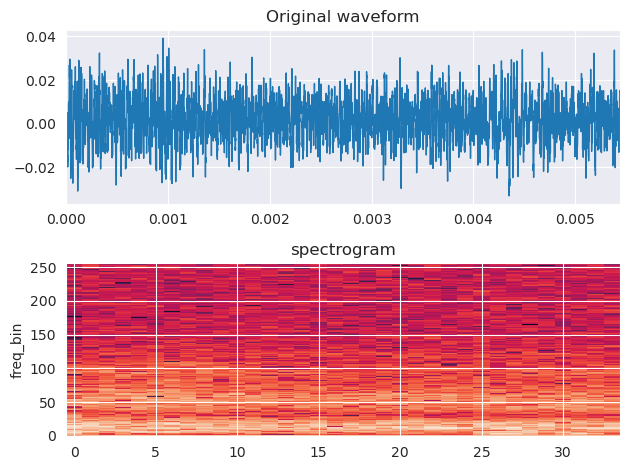

In [14]:
fig, axs = plt.subplots(2, 1)
plot_waveform(x_reshape, sr=sample_rate, title="Original waveform", ax=axs[0])
plot_spectrogram(spectrogram[0], title="spectrogram", ax=axs[1])
plt.tight_layout()

In [10]:
import numpy as np

from scipy import signal

from scipy.fft import fftshift

import matplotlib.pyplot as plt

rng = np.random.default_rng()

In [9]:
Sxx.shape, spectrogram.shape

NameError: name 'Sxx' is not defined

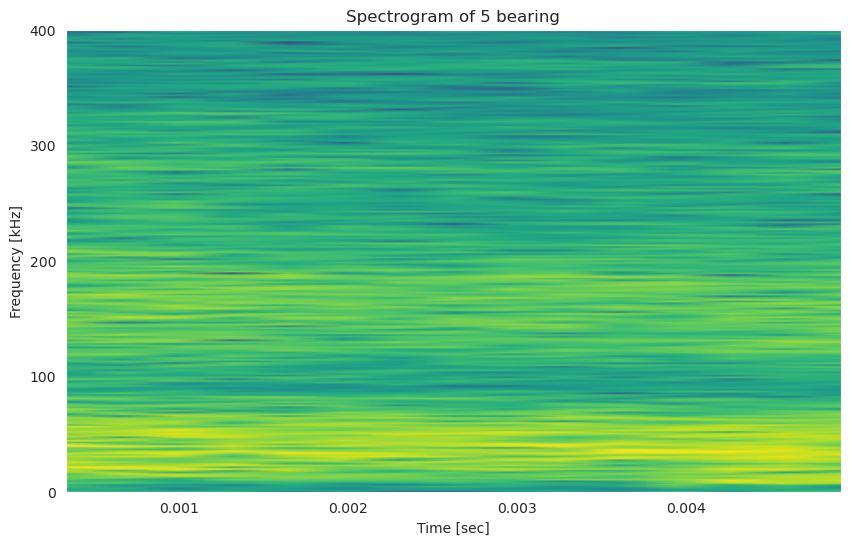

In [12]:
frequencies, times, Sxx = signal.spectrogram(train_set[6][0].reshape(-1),fs=sample_rate ,nperseg=1024, noverlap=512)
plt.figure(figsize=(10, 6))
plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud', cmap='viridis')
# plt.colorbar(label='Intensity [dB]')
plt.ylabel('Frequency [kHz]')
plt.xlabel('Time [sec]')
plt.title(f'Spectrogram of {train_set[12500][1]} bearing')
plt.ylim(0, 400000)  # Limit frequency axis to 50 kHz
plt.yticks(np.arange(0, 410000, 100000), labels=np.arange(0, 410, 100)) # Limit frequency axis to 50 kHz for better visualization
plt.show()

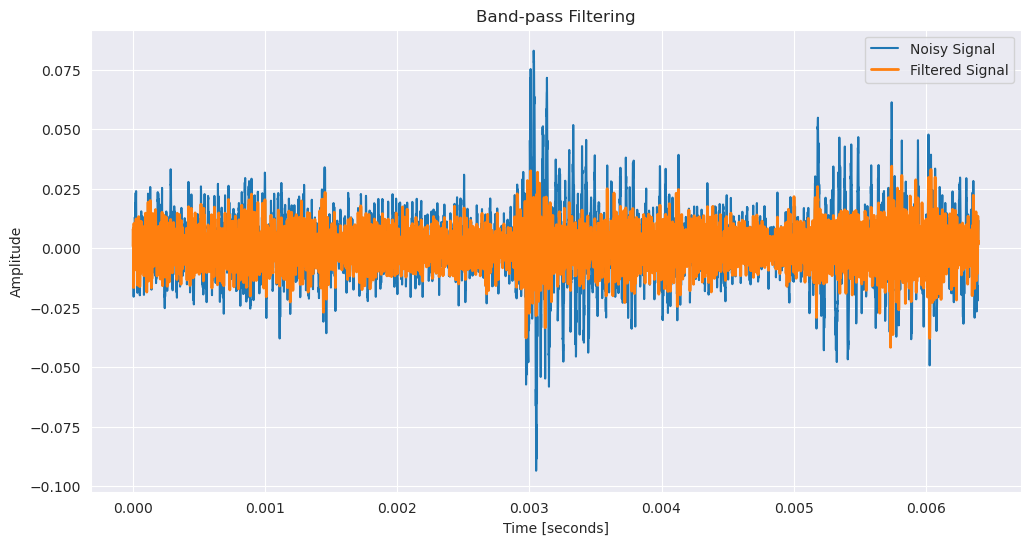

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# Generate example ultrasound time series data with 10,000 samples
np.random.seed(0)
sample_rate = 1562500  # 1.5625 MHz
duration = 10000 / sample_rate  # seconds
time = np.linspace(0, duration, 10000, endpoint=False)
frequency = 500000  # 500 kHz, typical ultrasound frequency
data = train_set[0][0].reshape(-1)
# Design a Butterworth band-pass filter
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

# Apply band-pass filter
lowcut = 40000  # 400 kHz
highcut = 500000  # 600 kHz
filtered_data = butter_bandpass_filter(data, lowcut, highcut, sample_rate)

# Plot original and filtered signals
plt.figure(figsize=(12, 6))
plt.plot(time, data, label='Noisy Signal')
plt.plot(time, filtered_data, label='Filtered Signal', linewidth=2)
plt.xlabel('Time [seconds]')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Band-pass Filtering')
plt.show()

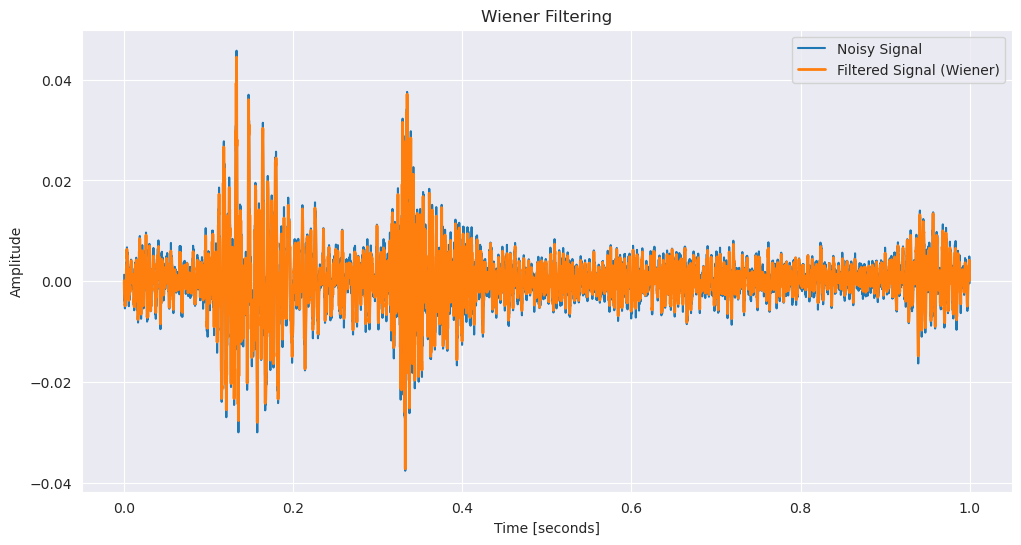

In [35]:
from scipy.signal import wiener
time = np.linspace(0, 1, 10000, endpoint=False)
# Apply Wiener filter
filtered_data_wiener = wiener(train_set[50][0].reshape(-1))

# Plot original and filtered signals
plt.figure(figsize=(12, 6))
plt.plot(time, train_set[50][0].reshape(-1), label='Noisy Signal')
plt.plot(time, filtered_data_wiener, label='Filtered Signal (Wiener)', linewidth=2)
plt.xlabel('Time [seconds]')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Wiener Filtering')
plt.show()

In [ ]:
np.random.seed(0)
sample_rate = 1562500  # 1.5625 MHz
duration = 1  # seconds
time = np.linspace(0, duration, sample_rate, endpoint=False)
frequency = 50  # Hz
data = train_set[12500][0]

# Perform FFT
fft_result = np.fft.fft(data)
fft_freq = np.fft.fftfreq(len(data), 1/sample_rate)

# Take the magnitude of the FFT and only keep the positive frequencies
fft_magnitude = np.abs(fft_result)[:len(data) // 2]
fft_freq = fft_freq[:len(data) // 2]

# Plot the FFT
plt.figure(figsize=(12, 6))
plt.plot(fft_freq / 1000, fft_magnitude)
plt.xlabel('Frequency (kHz)')
plt.ylabel('Magnitude')
plt.title('FFT of the Signal')
plt.grid(True)
plt.xlim(0, 50)  # Limit frequency axis to 50 kHz
plt.show()

In [48]:
Sxx.shape

(513, 3050)

In [ ]:
import numpy as np

from scipy import signal

from scipy.fft import fftshift

import matplotlib.pyplot as plt

rng = np.random.default_rng()

In [ ]:

test_dataloader = DataLoader(test_data, batch_size=512, shuffle=False)
models = {"neuro_net": neuro_net, "dummy": dummy_classifier}
torch.cuda.empty_cache()
# print(np.equal(neuro_net.targets, y_test))

for name, model in models.items():
    outputs = np.empty((0,), dtype=np.float32)
    targets = np.empty((0,), dtype=np.longdouble).flatten()
    for i, (input, target) in enumerate(test_dataloader):
        input, target = input.numpy(), target.numpy()
        output = model.predict(input)
        outputs = np.concatenate((outputs, output), axis=0)
        targets = np.concatenate((targets, target), axis=0)
    model.plot_confusion_matrix(outputs, targets)

In [5]:
final = []
a = torch.rand(2,1)
b = torch.rand(2,1)
final.extend(a)
final.extend(b)

In [7]:
import torch
a = [torch.rand(20,1,500) for i in range(20)]
torch.cat(a).shape

torch.Size([400, 1, 500])

In [ ]:
# TODO: plot confusion matrix for multiple models
# TODO: plot matrix for num_of_samples x channels. Probability distributions in columns.
# TODO: Noise, scaling(0.2,5)
# TODO: MEL spectrogram (for music)
# TODO: ml models: HIVE-COTE, Linear model, Random forest